In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df=pd.read_csv('Chapter5_ROP_DataSet.csv')
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Hole Depth,7934.0,10487.930804,2289.973781,6524.000,8500.250,10487.500,12469.750,14454.00
Hook Load,7934.0,129.672107,7.724432,107.200,123.800,129.500,134.400,156.40
Rotary RPM,7934.0,65.961054,24.280720,9.000,49.000,70.000,90.000,101.00
Rotary Torque,7934.0,11.459822,3.386672,2.701,9.096,11.373,14.198,20.05
Weight on Bit,7934.0,19.826758,5.611785,0.000,16.300,20.400,23.900,39.40
Differential Pressure,7934.0,520.255067,142.477894,2.900,429.350,565.900,627.700,783.30
Gamma at Bit,7934.0,211.783237,81.536917,54.120,148.240,204.710,235.290,600.00
Rate Of Penetration,7934.0,143.107280,55.738087,1.610,100.160,161.160,185.240,259.29


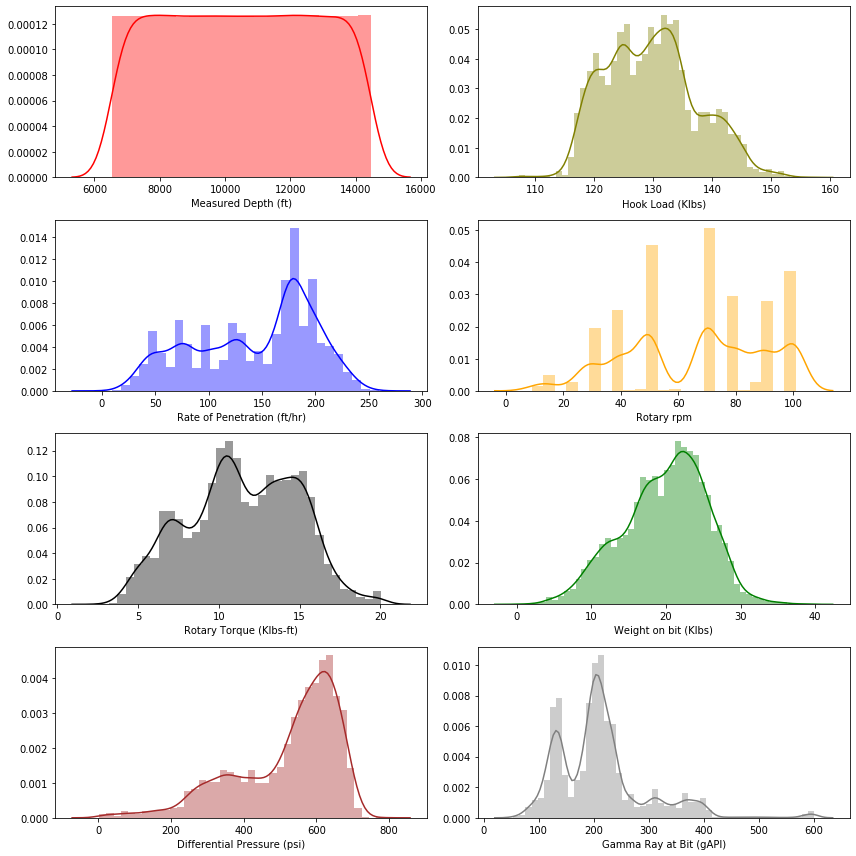

In [ ]:
f, axes =plt.subplots(4, 2, figsize=(12, 12))
sns.distplot(df['Hole Depth'], color="red", ax=axes[0, 0],
axlabel='Measured Depth (ft)')
sns.distplot(df['Hook Load'], color="olive", ax=axes[0, 1],
axlabel='Hook Load (Klbs)')
sns.distplot(df['Rate Of Penetration'], color="blue", ax=axes
[1, 0],axlabel='Rate of Penetration (ft/hr)')
sns.distplot(df['Rotary RPM'], color="orange", ax=axes[1, 1],
axlabel='Rotary rpm')
sns.distplot(df['Rotary Torque'], color="black",
ax=axes[2, 0],axlabel='Rotary Torque (Klbs-ft)')
sns.distplot(df['Weight on Bit'], color="green",
ax=axes[2, 1],axlabel='Weight on bit (Klbs)')
sns.distplot(df['Differential Pressure'], color="brown",
ax=axes[3, 0],axlabel='Differential Pressure (psi)')
sns.distplot(df['Gamma at Bit'], color="gray", ax=axes[3, 1],
axlabel='Gamma Ray at Bit (gAPI)')
plt.tight_layout()

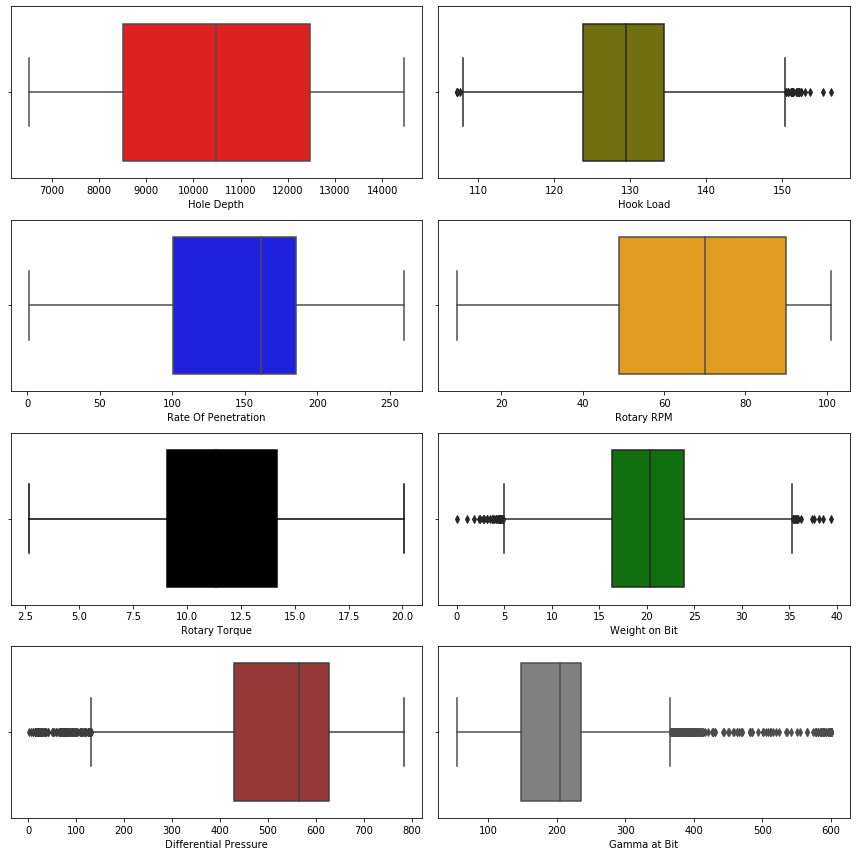

In [ ]:
f, axes =plt.subplots(4, 2, figsize=(12, 12))
sns.boxplot(df['Hole Depth'], color="red", ax=axes[0, 0])
sns.boxplot(df['Hook Load'], color="olive", ax=axes[0, 1])
sns.boxplot(df['Rate Of Penetration'], color="blue",
ax=axes[1, 0])
sns.boxplot(df['Rotary RPM'], color="orange", ax=axes[1, 1])
sns.boxplot(df['Rotary Torque'], color="black", ax=axes[2, 0])
sns.boxplot(df['Weight on Bit'], color="green", ax=axes[2, 1])
sns.boxplot(df['Differential Pressure'], color="brown",
ax=axes[3, 0])
sns.boxplot(df['Gamma at Bit'], color="gray", ax=axes[3, 1])
plt.tight_layout()

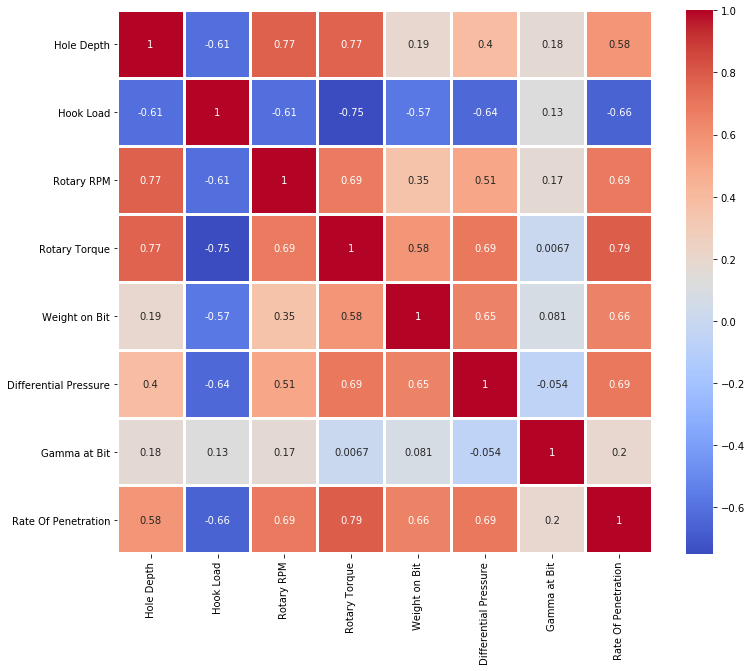

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, linecolor='white',
linewidths=2, cmap='coolwarm')

**Paso 1:Separar variables**

In [ ]:
# Seleccionar variables de entrada y salida
X_array = df[['Hole Depth', 'Hook Load', 'Rotary RPM', 'Rotary Torque',
              'Weight on Bit', 'Differential Pressure', 'Gamma at Bit']].values
y_array = df['Rate Of Penetration'].values


**Paso** **2** **Escalado**

In [ ]:

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_array)
y_scaled = scaler_y.fit_transform(y_array.reshape(-1, 1))


**Paso** **3**:**crear** **secuencias** **temporales**

In [ ]:
seq_len = 20  # ventana de 14 pasos
x_seq, y_seq = [], []

for i in range(len(X_scaled) - seq_len):
    x_seq.append(X_scaled[i:i+seq_len])
    y_seq.append(y_scaled[i+seq_len])

x_seq = np.array(x_seq)
y_seq = np.array(y_seq)


**Paso** **4** **:** **Split** **temporal**

In [ ]:
n = len(x_seq)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

x_train, y_train = x_seq[:train_end], y_seq[:train_end]
x_val, y_val = x_seq[train_end:val_end], y_seq[train_end:val_end]
x_test, y_test = x_seq[val_end:], y_seq[val_end:]


**Paso 5:Tensores**

In [ ]:
import torch

In [ ]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val   = torch.tensor(x_val,   dtype=torch.float32)
y_val   = torch.tensor(y_val,   dtype=torch.float32)
x_test  = torch.tensor(x_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.float32)


In [ ]:
class InformerDataset(Dataset):
    def __init__(self, x_data, y_data, label_len=10):
        self.x_data = x_data
        self.y_data = y_data
        self.label_len = label_len  # longitud del contexto para el decoder

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        enc_x = self.x_data[idx].to(torch.float32)  # asegurar float32
        dec_len = 1  # predecimos solo un paso
        dec_x = torch.zeros((self.label_len + dec_len, enc_x.shape[1]),
                            dtype=torch.float32)   # forzar float32
        dec_x[:self.label_len] = enc_x[-self.label_len:]
        y = self.y_data[idx].to(torch.float32)  # también asegurar float32
        return enc_x, dec_x, y


In [ ]:
batch = next(iter(train_loader))
print([b.dtype for b in batch])


[torch.float32, torch.float32, torch.float32]


**Paso 6: Dataset y DataLoader**

In [ ]:
train_dataset = InformerDataset(x_train, y_train, label_len=14)
val_dataset = InformerDataset(x_val, y_val, label_len=14)
test_dataset = InformerDataset(x_test, y_test, label_len=14)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# **Informer**

In [ ]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

class DataEmbedding(nn.Module):
    def __init__(self, input_size, d_model, dropout=0.1):
        super().__init__()
        self.value_embedding = nn.Linear(input_size, d_model)
        self.position_encoding = PositionalEncoding(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.value_embedding(x)
        x = self.position_encoding(x)
        return self.dropout(x)

class ProbSparseSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, q, k, v):
        B, L, _ = q.size()
        H = self.n_heads
        D = self.head_dim

        q = self.q_proj(q).view(B, L, H, D).transpose(1, 2)
        k = self.k_proj(k).view(B, L, H, D).transpose(1, 2)
        v = self.v_proj(v).view(B, L, H, D).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(D)

        top_k = max(1, int(L * 0.1))
        threshold_values, _ = torch.topk(scores, top_k, dim=-1)
        thresholds = threshold_values[..., -1:].expand_as(scores)
        mask = scores >= thresholds

        masked_scores = torch.where(mask, scores, torch.full_like(scores, float('-inf')))
        attn = torch.softmax(masked_scores, dim=-1)

        context = torch.matmul(attn, v)
        context = context.transpose(1, 2).contiguous().view(B, L, H * D)

        return self.out_proj(context)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=256, dropout=0.1):
        super().__init__()
        self.self_attn = ProbSparseSelfAttention(d_model, n_heads)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x2 = self.norm1(x + self.dropout(self.self_attn(x, x, x)))
        x3 = self.norm2(x2 + self.dropout(self.ffn(x2)))
        return x3

class Encoder(nn.Module):
    def __init__(self, layer, num_layers, d_model, distil=True):
        super().__init__()
        self.layers = nn.ModuleList([layer for _ in range(num_layers)])
        self.distil = distil
        self.pooling = nn.AvgPool1d(kernel_size=2, stride=2) if distil else None
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.distil and i != len(self.layers) - 1:
                x = self.pooling(x.permute(0, 2, 1)).permute(0, 2, 1)
        return self.norm(x)

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=256,dropout=0.05):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, tgt_mask=None):
        x2 = self.norm1(x + self.dropout(self.self_attn(x, x, x, attn_mask=tgt_mask)[0]))
        x3 = self.norm2(x2 + self.dropout(self.cross_attn(x2, memory, memory)[0]))
        x4 = self.norm3(x3 + self.dropout(self.ffn(x3)))
        return x4

class Decoder(nn.Module):
    def __init__(self, layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([layer for _ in range(num_layers)])

    def forward(self, x, memory, tgt_mask=None):
        for layer in self.layers:
            x = layer(x, memory, tgt_mask)
        return x

class Informer(nn.Module):
    def __init__(self, input_size, d_model, n_heads, e_layers, d_layers, out_size, dropout=0.1, distil=True):
        super().__init__()
        self.enc_embedding = DataEmbedding(input_size, d_model, dropout)
        self.dec_embedding = DataEmbedding(input_size, d_model, dropout)

        enc_layer = EncoderLayer(d_model, n_heads, dropout=dropout)
        self.encoder = Encoder(enc_layer, e_layers, d_model, distil=distil)

        dec_layer = DecoderLayer(d_model, n_heads, dropout=dropout)
        self.decoder = Decoder(dec_layer, d_layers)

        self.projection = nn.Linear(d_model, out_size)

    def forward(self, enc_x, dec_x):
        enc_x = self.enc_embedding(enc_x)
        dec_x = self.dec_embedding(dec_x)

        memory = self.encoder(enc_x)

        seq_len = dec_x.size(1)
        tgt_mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1).to(dec_x.device)

        out = self.decoder(dec_x, memory, tgt_mask=tgt_mask)
        return self.projection(out[:, -1, :])


In [ ]:
def evaluate(model, test_loader):
    model.eval()
    preds, targets = [], []
    device = next(model.parameters()).device
    with torch.no_grad():
        for enc_x, dec_x, y in test_loader:
            enc_x, dec_x = enc_x.to(device), dec_x.to(device)
            output = model(enc_x, dec_x)
            preds.append(output.cpu())
            targets.append(y)

    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()
    return preds, targets



In [ ]:
def train_informer(model, train_loader, val_loader, epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for enc_x, dec_x, y in train_loader:
            enc_x, dec_x, y = enc_x.to(device), dec_x.to(device), y.to(device)

            optimizer.zero_grad()
            output = model(enc_x, dec_x)

            loss = criterion(output.squeeze(), y.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for enc_x, dec_x, y in val_loader:
                enc_x, dec_x, y = enc_x.to(device), dec_x.to(device), y.to(device)
                output = model(enc_x, dec_x)
                loss = criterion(output.squeeze(), y.squeeze())
                val_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

    return model

In [ ]:
model = Informer(
    input_size=7,     # cambia según tus datos
    d_model=512,
    n_heads=8,
    e_layers=3,
    d_layers=2,
    out_size=1        # una salida: Pwf
)

model = train_informer(model, train_loader, val_loader, epochs=200, lr=1e-4)

preds, targets = evaluate(model, test_loader)


Epoch 1/200, Train Loss: 0.2668, Val Loss: 0.0403
Epoch 2/200, Train Loss: 0.0788, Val Loss: 0.0247
Epoch 3/200, Train Loss: 0.0645, Val Loss: 0.0242
Epoch 4/200, Train Loss: 0.0588, Val Loss: 0.0240
Epoch 5/200, Train Loss: 0.0466, Val Loss: 0.0242
Epoch 6/200, Train Loss: 0.0434, Val Loss: 0.0244
Epoch 7/200, Train Loss: 0.0401, Val Loss: 0.0227
Epoch 8/200, Train Loss: 0.0365, Val Loss: 0.0222
Epoch 9/200, Train Loss: 0.0358, Val Loss: 0.0225
Epoch 10/200, Train Loss: 0.0325, Val Loss: 0.0224
Epoch 11/200, Train Loss: 0.0299, Val Loss: 0.0212
Epoch 12/200, Train Loss: 0.0285, Val Loss: 0.0211
Epoch 13/200, Train Loss: 0.0275, Val Loss: 0.0214
Epoch 14/200, Train Loss: 0.0257, Val Loss: 0.0203
Epoch 15/200, Train Loss: 0.0258, Val Loss: 0.0201
Epoch 16/200, Train Loss: 0.0239, Val Loss: 0.0198
Epoch 17/200, Train Loss: 0.0242, Val Loss: 0.0199
Epoch 18/200, Train Loss: 0.0264, Val Loss: 0.0196
Epoch 19/200, Train Loss: 0.0238, Val Loss: 0.0190
Epoch 20/200, Train Loss: 0.0235, Val Lo

KeyboardInterrupt: 

**Grafica**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 4))

# Black dots for true data points
plt.plot(targets, 'k.', label='True', markersize=4)

# Intense blue line for predictions
plt.plot(preds, label='Predicted (Informer)', color='#0057B7', linestyle='-', linewidth=1.5)

plt.title('ROP', fontsize=12)
plt.xlabel('Hole Depth', fontsize=11)
plt.ylabel('Rate Of Penetration(ROP)', fontsize=11)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

# Remove top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Format Y axis
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

plt.tight_layout()
plt.savefig('pwf_informer_intense_blue.png', dpi=300)
plt.show()


**Metricas**

In [ ]:
import numpy as np

# Convertir tensores a arrays si es necesario
if isinstance(preds, torch.Tensor):
    preds = preds.detach().cpu().numpy()
if isinstance(targets, torch.Tensor):
    targets = targets.detach().cpu().numpy()

# Evitar división por cero en MAPE
epsilon = 1e-8

# Número de datos
n = len(targets)

# Media de los reales
y_mean = np.mean(targets)
r2=1-(np.sum((preds-targets)**2)/np.sum((targets-y_mean)**2))
# RMSE
rmse = np.sqrt(np.mean((preds - targets) ** 2))

# RSE
rse = np.sum((preds - targets) ** 2) / np.sum((targets - y_mean) ** 2)

# RAE
rae = np.sum(np.abs(preds - targets)) / np.sum(np.abs(targets - y_mean))


mape = np.mean(np.abs((preds - targets) / np.maximum(np.abs(targets), epsilon))) * 100


# Mostrar resultados
print(f"RMSE: {rmse:.4f}")
print(f"RSE:  {rse:.4f}")
print(f"RAE:  {rae:.4f}")
print(f"MAPE: {mape:.2f}%")

In [ ]:
df_blind=pd.read_csv('Chapter5_ROP_Blind_DataSet.csv')

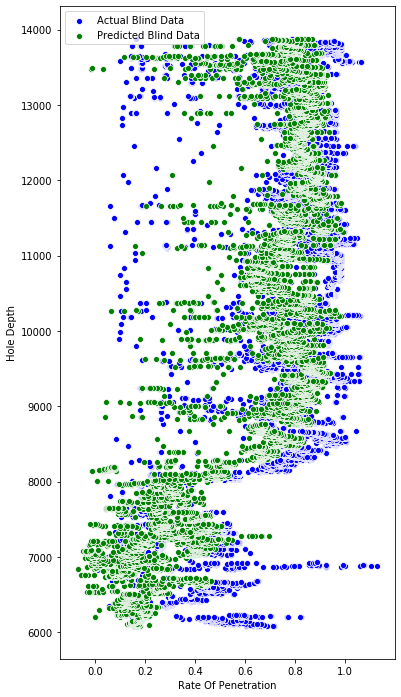

In [ ]:
plt.figure(figsize=(6,12))
sns.scatterplot(y_scaled_blind, df_blind['Hole Depth'],
label='Actual Blind Data', color='blue')
sns.scatterplot(y_pred_blind, df_blind['Hole Depth'],
label='Predicted Blind Data', color='green')

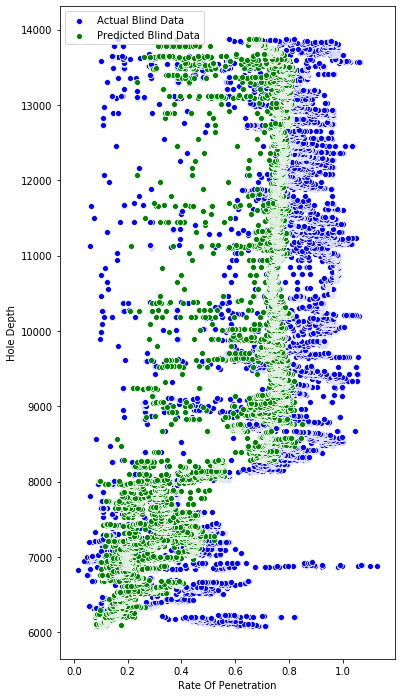

In [ ]:
plt.figure(figsize=(6,12))
sns.scatterplot(y_scaled_blind, df_blind['Hole Depth'],
label='Actual Blind Data', color='blue')
sns.scatterplot(y_pred_blind, df_blind['Hole Depth'], label='\
Predicted Blind Data', color='green')